# Pytorch中级实战(1): 使用YoloV3实现目标检测(Object Detection) - 最简单的Yolo代码

# 本文内容

目前Github上的Yolo代码大多都是工业级别的，里面包含了无数的trick，相当复杂，很难看懂。即便有一些提纯的Yolo代码也都是py文件，而非Jupyter，阅读困难且没有讲解。所以我写了本篇Yolo实战，去掉所有trick，仅保留Yolo最精华的部分，使用最朴实无华的代码，让任何人都可以轻松读懂Yolo代码。

本篇使用的模型其实是YoloV3-tiny，其实都差不多。因为我觉得Yolo最简单的部分就是模型部分，反而其他部分比较困难。

简单起见，本文只使用训练集，不使用验证集，也不计算mAP。

本篇代码可以在[该Git仓库](https://github.com/iioSnail/pytorch_deep_learning_examples)找到。 你也可以直接使用Google Colab（[链接地址](https://colab.research.google.com/github/iioSnail/pytorch_deep_learning_examples/blob/main/101_object_detection_yolov3.ipynb)）运行。

# 环境配置

本篇使用的环境如下：

```
python==3.8.5
torch==1.12.1
torchvision==0.13.1
matplotlib==3.3.4
```

导入本篇需要使用的依赖：

In [660]:
import os
import math
import time
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

从导包就可以看出来本篇的Yolo代码有多简介了吧。

# 工具函数

In [661]:
def xywh2xyxy(x):
    """
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    将 x,y,w,h （中心点坐标+宽高）转化为 xyxy（左上角坐标+右下角坐标）
    """
    y = x.clone()
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

In [662]:
def box_iou(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(box1.T)
    area2 = box_area(box2.T)

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    inter = (torch.min(box1[:, None, 2:], box2[:, 2:]) - torch.max(box1[:, None, :2], box2[:, :2])).clamp(0).prod(2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

# 全局参数

定义一些全局参数，方便后续使用：

In [663]:
# 我们本次训练使用的是CoCo数据集，一共80个类别。
classes_name = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
                'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
                'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
                'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
                'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
                'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
                'scissors', 'teddy bear', 'hair drier', 'toothbrush']

# 类别总数
n_classes = len(classes_name)
# 模型的输出数量。其比类别数多输出5个数值，分别为置信度，“xy坐标点”，“宽高“（模型训练章节会讲解）。
n_output = n_classes + 5

# 将图片Resize到640x640
image_size = 640
batch_size = 4

print("总类别数：", n_classes)

# 训练数据集的图片和Label所在的目录
dataset_image_dir = Path('./coco128/images/train2017')
dataset_label_dir = Path('./coco128/labels/train2017')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device:", device)

总类别数： 80
Device: cpu


# 工具函数

In [789]:
def convert_label_to_cxywh(image, label):
    """
    数据集中的label为(class_index, x_center, y_center, width, height)，且坐标都是小数。
    为了方便图形绘制，我们将中心点坐标转换为左上角坐标，同时将小数转换为整数
    """
    im_w, im_h = image.size(2), image.size(1)

    cxywh_list = []
    for obj in label:
        class_index, x_center, y_center, width, height = obj
        x = (x_center - width / 2) * im_w
        y = (y_center - height / 2) * im_h
        w = width * im_w
        h = height * im_h
        cxywh_list.append((class_index, x, y, w, h))
    return cxywh_list

In [790]:
def im_show(image, label):
    """
    绘制图像及其中的物体边框
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    label = convert_label_to_cxywh(image, label)
    for obj in label:
        class_index, x, y, w, h = obj
        rect = plt.Rectangle(xy=(x, y), width=w, height=h, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        print(class_index)
        plt.text(x, y, classes_name[class_index.int()], color='red', fontsize=16)
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

# 数据处理

在原代码中，Yolo在数据处理上做了大量的工作，包括各种数据增强、等比例缩放等。这里我们就最简单，啥都不做，就是图片和标签。在缩放上，我们也是简单粗暴的直接将其Resize成640x640。由于YoloV3使用的数据集的坐标和宽高也都是相对坐标(`[0-1]`), 所以也不需要因为Resize做特别处理。

数据集我们就使用TODO。

数据集主要包含两部分，图片文件和Label文件，名称相同的是一对儿。 例如，图片文件是这样：

```
000000000009.jpg
000000000025.jpg
000000000030.jpg
000000000034.jpg
```

标签文件则长这样：

```
000000000009.txt
000000000025.txt
000000000030.txt
000000000034.txt
```

随便你打开个标签文件，我们会看到这样的数据：

```
25 0.475759 0.414523 0.951518 0.672422
0 0.671279 0.617945 0.645759 0.726859
```

该文件包含两行数据，也就是对应图片中有两个物体。每行包含5个数据，分别为`class_index`（物体类别）, `center_x`, `center_y`（物体中心点坐标）, `w`, `h`（物体宽高）。

其中中心点坐标和宽高都是相对位置，所以是0-1之间的数。

有了对数据集的了解，我们就可以来定义Dataset了，Dataset就是简单的对图片进行正则化（除以255，把图片弄到0-1的区间），提取标签。

In [826]:
class YoloDataset(Dataset):

    def __init__(self):
        # 获取训练集图片列表
        self.images = os.listdir(dataset_image_dir)

    def __getitem__(self, index):
        image_filename = self.images[index]
        # 读取图片，Resize到640x640，并进行正则化
        image = torchvision.io.read_image(str(dataset_image_dir / image_filename))
        image = transforms.Resize((image_size, image_size))(image)
        image = image / 255.

        # 把文件名jpg换成txt就是标签文件的名称
        label_filename = image_filename[:-3] + 'txt'
        label_path = dataset_label_dir / label_filename

        # 使用pandas来读取标签文件
        label = torch.from_numpy(pd.read_csv(label_path, delimiter=' ', header=None).to_numpy())

        return image, label

    def __len__(self):
        return 1 # TODO
        # return len(self.images)

In [827]:
dataset = YoloDataset()

定义好Dataset后，我们来看一眼，并绘制一下：

In [828]:
image, label = dataset.__getitem__(1)
print("image shape:", image.size())
print("label:", label)

image shape: torch.Size([3, 640, 640])
label: tensor([[23.0000,  0.7703,  0.4897,  0.3359,  0.6976],
        [23.0000,  0.1860,  0.9016,  0.2063,  0.1296]], dtype=torch.float64)


tensor(23., dtype=torch.float64)
tensor(23., dtype=torch.float64)


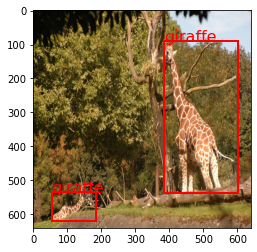

In [829]:
im_show(image, label)

这里绘制的图片是缩放后的，所以大小为640x640

接下来开始定义DataLoader，由于每个图片的物体数不一样，即label的shape不一样，所以其不能直接组成一个batch，因此我们需要一个collate_fn将其组成一个batch。

In [830]:
def collate_fn(batch):
    image_list = []
    label_list = []
    for i, (image, label) in enumerate(batch):
        image_list.append(image)
        # 给label最前面加一列。目的是当多张图片组成一个batch后，能区分哪个物体是属于哪张图片的
        label = torch.concat([torch.full((label.size(0), 1), fill_value=i), label], dim=1)
        label_list.append(label)
    """
    多张图片使用stack摞起来，例如4张图片，shape都为(3, 640, 640)
                         则结果为(4, 3, 640, 640)
    多张图片的多个物体使用concat连接，因为他们Shape不一样，所以无法使用Stack
                        例如4张图片的Label Shape分别为(4, 6), (1, 6), (2, 6), (3, 6)
                        则结果为(10, 6)
    """
    return torch.stack(image_list), torch.concat(label_list)

In [831]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

dataloader构建好以后，也是来简单看一下

In [832]:
images, labels = next(iter(dataloader))
print("image shape:", images.size())
print("labels shape:", label.size())

image shape: torch.Size([1, 3, 640, 640])
labels shape: torch.Size([2, 5])


# 模型搭建

数据准备完毕后，我们就可以来正式进入Yolo算法了，我们首先来搭建Yolo模型。本文使用的是YoloV3-Tiny模型，其最后输出两个窗口（原始输出是3个），不过都差不多。下图是YoloV3-Tiny的模型图，TODO

原论文中的YoloV3图忽略了很多细节，所以还是主要参考YoloV3源码中的架构：

```
anchors:
  - [10,14, 23,27, 37,58]  # P4/16 # 负责检测小物体
  - [81,82, 135,169, 344,319]  # P5/32 # 负责检测大物体

# YOLOv3-tiny backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [16, 3, 1]],  # 0
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 1-P1/2
   [-1, 1, Conv, [32, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 3-P2/4
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 5-P3/8
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 7-P4/16
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 9-P5/32
   [-1, 1, Conv, [512, 3, 1]],
   [-1, 1, nn.ZeroPad2d, [[0, 1, 0, 1]]],  # 11
   [-1, 1, nn.MaxPool2d, [2, 1, 0]],  # 12
  ]

# YOLOv3-tiny head
head:
  [[-1, 1, Conv, [1024, 3, 1]],
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [512, 3, 1]],  # 15 (P5/32-large)

   [-2, 1, Conv, [128, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 8], 1, Concat, [1]],  # cat backbone P4
   [-1, 1, Conv, [256, 3, 1]],  # 19 (P4/16-medium)

   [[19, 15], 1, Detect, [nc, anchors]],  # Detect(P4, P5)
]
```

上述的模型架构中，主要包含两部分：

- backbone: 模型主干部分，是一个卷积神经网络，负责对图片进行特征提取
- head: 模型的预测部分，主要负责输出不同尺度的预测结果。

源码的配置文件的每行包含四个参数，分别为：

- from: 表示本层的输入来源于哪。`-1`就代表本层的输入来源于上一层的输出，同理`-2`就表示来源为上上层的输出。如果是`8`，则表示来源于第8层的输出。（从0开始计算）
- number: 表示本层需要重复堆叠几次。在YoloV3-Tiny中该值都为1，所以可以忽略不计。
- module: 表示本层的网络模块是啥。如果是`nn.`开头的，则是pytorch内置的模块，否则就是自定义的。
- args: 表示本层网络模块的输入参数。例如对于Conv的参数`[16, 3, 1]`就表示输出通道为16, kernal_size为3， stride为1。



上面的配置文件中，还包含anchor配置，我们这里也将其定义出来：

In [833]:
anchors_list = [
    [[10, 13], [33, 23], [62, 45]],
    [[59, 119], [156, 198], [373, 326]]
]
# 按照上面的定义，每个窗口anchor的数量为3
n_anchors = 3

接下来我们就可以开始按照配置来构建网络，我们首先需要把网络自定的模块定义出来。

在Yolo中，Conv是指卷积层，它是由三部分组成的，`nn.Conv2d`、`BatchNorm`和激活函数`SiLU`（和Relu长的差不多）。

In [834]:
class Conv(nn.Module):
    # Standard convolution
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1):
        super().__init__()
        # 这里padding全取 kernal_size//2 的原因是 TODO
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

接下来是Concat，这个比较简单，就是将两个结果Concat到一起，主要是用于高层特征与低层特征融合的。

In [835]:
class Concat(nn.Module):
    # Concatenate a list of tensors along dimension
    def __init__(self, dimension=1):
        super().__init__()
        self.d = dimension

    def forward(self, x):
        return torch.cat(x, self.d)

之后就是后一个Detect层，它是一个`ModuleList`，最终会输出两个不同尺度的特征图。这个的实现稍微复杂一点：

In [836]:
class Detect(nn.Module):

    def __init__(self):
        super().__init__()

        # 最后输出两种尺度的特征图。输出通道为 n_anchors * n_output。在本文中，就是3*85。
        self.model = nn.ModuleList(
            [
                nn.Conv2d(256, n_anchors * n_output, 1, 1),
                nn.Conv2d(512, n_anchors * n_output, 1, 1)
            ],
        )

    def forward(self, x):
        outputs = []
        # 因为模型modelList, 所以要for循环分别处理。
        for i in range(len(self.model)):
            # 最后输出两个不同尺度的特征图。
            output = self.model[i](x[i])
            # 由于有3个anchor，所以需要将output的Shape从(batch_size, 255, 20, 20)转换为(batch_size, 3, 20 ,20, 85)
            bs, _, ny, nx = output.shape
            output = output.view(bs, n_anchors, n_output, ny, nx).permute(0, 1, 3, 4, 2).contiguous()

            outputs.append(output)
        return outputs

构建完Yolo需要的网络模块，接下来我们正式构建YoloV3-Tiny模型，这里我就简单粗暴的一层一层定义：

In [837]:
class YoloV3Tiny(nn.Module):

    def __init__(self):
        super(YoloV3Tiny, self).__init__()
        self.backbone_0 = Conv(3, 16, 3, 1)  # 0
        self.backbone_1 = nn.MaxPool2d(2, 2, 0)  # 1
        self.backbone_2 = Conv(16, 32, 3, 1)
        self.backbone_3 = nn.MaxPool2d(2, 2, 0)  # 3
        self.backbone_4 = Conv(32, 64, 3, 1)
        self.backbone_5 = nn.MaxPool2d(2, 2, 0)  # 5
        self.backbone_6 = Conv(64, 128, 3, 1)
        self.backbone_7 = nn.MaxPool2d(2, 2, 0)  # 7
        self.backbone_8 = Conv(128, 256, 3, 1)
        self.backbone_9 = nn.MaxPool2d(2, 2, 0)  # 9
        self.backbone_10 = Conv(256, 512, 3, 1)
        self.backbone_11 = nn.ZeroPad2d([0, 1, 0, 1])  # 11
        self.backbone_12 = nn.MaxPool2d(2, 1, 0)  # 12

        self.head_13 = Conv(512, 1024, 3, 1)
        self.head_14 = Conv(1024, 256, 1, 1)
        self.head_15 = Conv(256, 512, 3, 1)
        self.head_16 = Conv(256, 128, 1, 1)
        self.head_17 = nn.Upsample(None, 2, 'nearest')
        self.head_18 = Concat(1)
        self.head_19 = Conv(384, 256, 3, 1)
        self.head_20 = Detect()

    def forward(self, images):
        outputs = self.backbone_0(images)
        outputs = self.backbone_1(outputs)
        outputs = self.backbone_2(outputs)
        outputs = self.backbone_3(outputs)
        outputs = self.backbone_4(outputs)
        outputs = self.backbone_5(outputs)
        outputs = self.backbone_6(outputs)
        outputs = self.backbone_7(outputs)
        outputs_8 = self.backbone_8(outputs)
        outputs = self.backbone_9(outputs_8)
        outputs = self.backbone_10(outputs)
        outputs = self.backbone_11(outputs)
        outputs = self.backbone_12(outputs)

        outputs = self.head_13(outputs)
        outputs_14 = self.head_14(outputs)
        outputs_15 = self.head_15(outputs_14)
        outputs = self.head_16(outputs_14)
        outputs = self.head_17(outputs)
        outputs = self.head_18([outputs, outputs_8])
        outputs_19 = self.head_19(outputs)
        outputs = self.head_20([outputs_19, outputs_15])
        return outputs

定义好后，我们来试一下：

In [838]:
model = YoloV3Tiny()

In [839]:
pred = model(images)
print("pred[0] shape:", pred[0].size())
print("pred[1] shape:", pred[1].size())

pred[0] shape: torch.Size([1, 3, 40, 40, 85])
pred[1] shape: torch.Size([1, 3, 20, 20, 85])


最终，我们将640x640的图片缩小成了两种尺度，分别为40x40和20x20。
显然40x40的更为精细，所以通常用来预测小物体，它对应的anchor是`[[10, 13], [33, 23], [62, 45]]`都比较小。
而20x20相对就比较粗，所以用来预测大物体，对应的anchor为`[[59, 119], [156, 198], [373, 326]]`

我们接下来计算下这两种尺度分别将原图缩小了多少倍：

640/40=16
640/20=32

分别缩小了16倍和32倍。所以我们之后的anchor等的处理也要相应的缩小16倍和32倍，这也是yolo中一个很重要的参数`strde`

In [840]:
stride = [16, 32]

定义好模型后，接下来正式进入模型训练，真正的难点来了。

# 模型训练

YoloV3-Tiny模型有两个尺度的输出，分别为`(batch_size, 3, 40, 40, 85)`和`(batch_size, 3, 20, 20, 85)`。在模型训练前，我们需要彻底搞懂这个是什么意思。我们以第二个作为例子来说明。

---
模型的输出为(batch_size, 3, 20, 20, 85)，其中3为3个anchor，20x20表示将原图分成20x20个窗口，85表示每个窗口针对自己的预测结果。假设我们的原图为：

<img src="./asserts/images/101_02.png" width="200">

“我只画了5x5个格子，实际应该是20x20个格子”。假设我们的原图只有一个物体（圆点是该物体的中心点），那么在这20x20个格子里，应该是第三个格子负责预测，假设没有引入anchor的话，我们希望的输出则为：

<img src="./asserts/images/101_03.png" width="200">

理想状态下，用tensor表示则为（tensor shape为(1, 1, 20, 20,85)）：

```
[?, ?, ?, ?, 0.02, ...],
[?, ?, ?, ?, 0.02, ...],
[x, y, w, h, 0.99, ...], # 第3个格子
[?, ?, ?, ?, 0.02, ...],
```

其中x,y表示物体相对本格子的中心点坐标，w,h表示物体的宽高，`0.99`和`0.02`表示置信度，越高表示这个格子有物体的概率越大。第三个格子因为有物体，所以置信度很高，而其他格子由于没有物体，所以置信度很低。

但是为什么要引入Anchor呢？因为想让模型直接预测出宽高很困难。举个现实生活中直观的例子, 我现在问你，辽宁号航母的造价大概是多少钱，不了解的同学虽然有很多生活经验，但是依然无法给出一个准确的答案，可能有些人会猜5亿？10亿？这些与实际答案都偏离甚远。但如果我给你一个锚点，航母的造价大概都在1000亿左右，那再让同学们预测就会准的多。

Anchor的机制同理，直接让网络预测出物体的宽高很困难，但是如果我们能给网络一个参考，比如，在一个640x640的图片中，一个物体的大小大概就是30x30或者60x60这样，你预测时候也不要给我宽高，你就给我偏移量。例如：你认为物体大小为40x40，那么针对这两个anchor，你给我的预测值就为10,10和-20,-20，这样相比直接让你给我宽高，对网络来说就容易多了。

一般人们都会给网络3个anchor作为参考，通常都是正方形、横长方形、竖长方形。每个格子就按这三种进行偏移量预测：

<img src="./asserts/images/101_01.png" width="500">

上图我只画了红色anchor的预测情况，其返回的是偏移量，这个会在计算Loss章节给出解释。

# 获取正样本

为了可以计算loss，我们要给出模型参考值，也就是按照模型输出的分格方式，计算出哪些格子有物体，物体的坐标是多少、物体相对anchor的偏移量是多少。所以我们要找出所有的正样本，即具有物体的格子。我们接下来要构造一个`build_targets`函数，来从labels中提取出一些数据，帮助我们后续的loss计算。

`build_targets(pred, labels)`一共有4个返回值，分别为：`target_cls, target_box, indices, anch`

假设我们的Labels为：

```
[[ 0, 22,  0.001,  0.001,  0.1,  0.1],
 [ 1, 33,  0.001,  0.001,  0.2,  0.2],
 [ 1, 44,  0.999,  0.999,  0.3,  0.3]]
```

即我们有两张图片，图片0中有一个物体，在左上角，坐标为(0.001, 0.001)，宽高都为0.1，类别为22。图片1中有两个物体，分别在左上角和右下角，类别分别为33和44。

此时如果我们调用`build_target(pred, labels)`（pred只是用于获取特征图尺寸，也就是40x40或20x20，并不直接参与targets的生成），则会得到如下结果：

---

target_cls:

```
[tensor([22, 33, 44, 22, 33, 44, 22, 33, 44]),
 tensor([22, 33, 44, 22, 33, 44, 22, 33, 44])]
```

target_cls是一个长度为2的list，2对应着YoloV3-Tiny输出的两种不同尺度的特征图。`target_cls[i]`中的数据是该尺度下的label的类别。`22,33,44`会重复3次是因为有三个anchor。

---

target_box:

```
[tensor([[ 0.0400,  0.0400,  4.0000,  4.0000],
         [ 0.0400,  0.0400,  8.0000,  8.0000],
         [ 0.9600,  0.9600, 12.0000, 12.0000],
         [ 0.0400,  0.0400,  4.0000,  4.0000],
         [ 0.0400,  0.0400,  8.0000,  8.0000],
         [ 0.9600,  0.9600, 12.0000, 12.0000],
         [ 0.0400,  0.0400,  4.0000,  4.0000],
         [ 0.0400,  0.0400,  8.0000,  8.0000],
         [ 0.9600,  0.9600, 12.0000, 12.0000]]),
 tensor([[0.0200, 0.0200, 2.0000, 2.0000],
         [0.0200, 0.0200, 4.0000, 4.0000],
         [0.9800, 0.9800, 6.0000, 6.0000],
         [0.0200, 0.0200, 2.0000, 2.0000],
         [0.0200, 0.0200, 4.0000, 4.0000],
         [0.9800, 0.9800, 6.0000, 6.0000],
         [0.0200, 0.0200, 2.0000, 2.0000],
         [0.0200, 0.0200, 4.0000, 4.0000],
         [0.9800, 0.9800, 6.0000, 6.0000]])]
```

同理，target_box也是一个长度为2的list。每行数据对应着每个anchor下在当前格子中的相对位置。例如：`[ 0.0400,  0.0400,  4.0000,  4.0000]`对应着label中`[ 0, 22,  0.001,  0.001,  0.1,  0.1]`的物体在40x40这个尺度下的相对数据。在整个图片中，物体中心点的相对坐标为`(0.001, 0.001)`，那么现在整个图片被分割成了40x40个格子，那么在第一个格子里，该物体相对这个格子的坐标就会变成`0.001 * 40 = 0.04`，同理看，宽高相对当前格子也需要乘以40。

---

indices:

```
[(tensor([0, 1, 2, 0, 1, 2, 0, 1, 2]),
  tensor([0, 0, 0, 1, 1, 1, 2, 2, 2]),
  tensor([ 0,  0, 39,  0,  0, 39,  0,  0, 39]),
  tensor([ 0,  0, 39,  0,  0, 39,  0,  0, 39])),
 (tensor([0, 1, 2, 0, 1, 2, 0, 1, 2]),
  tensor([0, 0, 0, 1, 1, 1, 2, 2, 2]),
  tensor([ 0,  0, 19,  0,  0, 19,  0,  0, 19]),
  tensor([ 0,  0, 19,  0,  0, 19,  0,  0, 19]))]
```

同理，indices是一个长度为2的list。`indices[i]`中又是一个长度为4的tuple。tuple中的4个tensor分别表示“第几条数据”、“第几个anchor”、“第几行”、“第几列”。

例如：`indices[0]`中数据含义为：在第0张图片的第0个anchor上的(0,0)这个格子上发现了一个物体；在第1张图片的第0个anchor上的(0,0)这个格子上发现了一个物体；在第2张图片上的第0个anchor上的(39,39)这个格子上发现了一个物体；后面依次类推。

---

anch:

```
[tensor([[0.6250, 0.8125],
         [0.6250, 0.8125],
         [0.6250, 0.8125],
         [2.0625, 1.4375],
         [2.0625, 1.4375],
         [2.0625, 1.4375],
         [3.8750, 2.8125],
         [3.8750, 2.8125],
         [3.8750, 2.8125]]),
 tensor([[ 1.8438,  3.7188],
         [ 1.8438,  3.7188],
         [ 1.8438,  3.7188],
         [ 4.8750,  6.1875],
         [ 4.8750,  6.1875],
         [ 4.8750,  6.1875],
         [11.6562, 10.1875],
         [11.6562, 10.1875],
         [11.6562, 10.1875]])]
```

同理，anch是一个长度为2的list。与indices中的anchor顺序一致，例如`[0.6250, 0.8125]`就对应着`[10,13]`这个anchor在40x40这个尺度上的缩放后的结果。即10/(640/40)=10/16=0.625。

---

从上面的返回值中可以看出有很多重复数据，那是因为我假设一个超参数`iou_t=0`了。 在我们定义的anchor中，并不是所有的anchor都适合物体的预测。例如：对于一个长颈鹿，正方形的anchor就不太适合：

<img src="./asserts/images/101_04.png" width="200">

这个时候我们就需要将这些重复数据去掉。所以我们需要计算一下anchor和target的iou，如果小于iou_t（通常为0.2），则忽略这个anchor。该函数在源码中为wh_iou：

In [841]:
def wh_iou(wh1, wh2):
    """
    计算wh1和wh2粗略iou。wh1和wh2并不包含位置信息，只有宽高。
    所以等同于将其左上角对其，然后计算其IOU
    """
    # Returns the nxm IoU matrix. wh1 is nx2, wh2 is mx2
    wh1 = wh1[:, None]  # [N,1,2]
    wh2 = wh2[None]  # [1,M,2]
    inter = torch.min(wh1, wh2).prod(2)  # [N,M]
    return inter / (wh1.prod(2) + wh2.prod(2) - inter)  # iou = inter / (area1 + area2 - inter)

接下来开始编写build_targets：

In [842]:
def build_targets(pred, labels):
    """
    构建targets对象，用于计算loss。
    :param pred: 模型的输出，仅用于获取40x40或20x20的特征图尺度。
    :param labels: 从dataloader获取的labels
    :return: 返回4个值，分别为 target_cls, target_box, indices, anch
    """
    # 获取label中的目标的数量
    n_targets = labels.shape[0]
    # 定义返回值的list。
    target_cls, target_box, indices, anch = [], [], [], []
    # 定义gain，方便后面计算，初始化gain为[1, 1, 1, 1, 1, 1]
    gain = torch.ones(6)

    # 遍历两种尺度的anchor
    for i, anchors in enumerate(anchors_list):
        # 之后的注释都会按照40x40尺度作为例子解释各行代码

        """
        例如对于第一个小尺度的anchor, 为[[10, 13], [33, 23], [62, 45]]
        由于模型将640x640的图片缩小到了40x40，缩小了16倍，所以anchor也要
        跟着缩小16倍。
        """
        anchors = torch.tensor(anchors).float() / stride[i]

        # 将gain变为[1, 1, 40, 40, 40, 40]，之所以是3,2,3,2是因为这段代码是支持不同宽高的。
        gain[2:] = torch.tensor(pred[i].shape)[[3, 2, 3, 2]]  # xyxy gain

        """
        定义个anchor_tensor，长这个样子
                tensor([[0, 0, 0, ...],
                        [1, 1, 1, ...],
                        [2, 2, 2, ...]])
        用于后面对anchor进行筛选。列数为target数量。
        """
        anchor_tensor = torch.arange(n_anchors).view(n_anchors, 1).repeat(1,
                                                               n_targets)  # anchor tensor, same as .repeat_interleave(nt)

        # 将targets与anchor进行匹配
        """
        target_i: targets的x,y,w,h都乘以40，转换为在当前格子中的相对大小。
        """
        target_i = labels * gain
        if n_targets:  # 如果存在target的话
            """
            计算该尺度下anchors和target的wh_iou，并筛选出iou>0.2的
            例如: j为：[[ True,  True, False, False],
                      [False,  True,  True, True],
                      [False, False,  True, False]]
                 有4列表示有4个物体。3行表示有3个anchor。
                 例如第2行第3列的True就表示，第三个物体的第2个anchor要保留，False则丢弃。
            """
            j = wh_iou(anchors, target_i[:, 4:6]) >= 0.2 # 超参数
            """
            anchor_i：过滤出这些target中要保留的anchor，例如：tensor([0, 0, 1, 1, 1, 2, 2])
            target_i：过滤出要保留的target
            """
            anchor_i, target_i = anchor_tensor[j], target_i.repeat(n_anchors, 1, 1)[j]  # filter

        """
        image_indices: 过滤后的图片index，例如：[0, 1, 1, 2, 3, 2, 3]
        clazz: 过滤后的图片类别。例如：[22, 33, 33, 44, 44, 44, 44]
        """
        image_indices, clazz = target_i[:, :2].long().T  # image_idx, class
        # 从target_i中拿出x,y
        grid_xy = target_i[:, 2:4]  # grid xy
        # 从target_i中拿出w,h
        grid_wh = target_i[:, 4:6]  # grid wh
        grid_ij = grid_xy.long()  # 匹配targets所在的grid cell左上角坐标
        grid_i, grid_j = grid_ij.T  # grid xy indices

        indices.append((image_indices, anchor_i, grid_j.clamp_(0, gain[3].long() - 1), grid_i.clamp_(0, gain[2].long() - 1)))
        target_box.append(torch.cat((grid_xy - grid_ij, grid_wh), 1))  # gt box相对anchor的x,y偏移量以及w,h
        anch.append(anchors[anchor_i])  # anchors
        target_cls.append(clazz)  # class

    return target_cls, target_box, indices, anch

编写完targets后，我们尝试下：

In [843]:
target_cls, target_box, indices, anch = build_targets(pred, labels)
print("target_cls:", target_cls)
print("target_box:", target_box)
print("indices:", indices)
print("anch:", anch)

target_cls: [tensor([], dtype=torch.int64), tensor([45])]
target_box: [tensor([], size=(0, 4), dtype=torch.float64), tensor([[ 0.5898,  0.7754, 19.1122, 11.9100]], dtype=torch.float64)]
indices: [(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64)), (tensor([0]), tensor([2]), tensor([13]), tensor([9]))]
anch: [tensor([], size=(0, 2)), tensor([[11.6562, 10.1875]])]


# 计算Loss

接下来开始计算Loss，同样，Loss计算比较复杂：

在本次box的loss计算时，使用的GIoU(Generalized Intersection over Union)，公式为：

$$
GIoU = IoU - \frac{|C-A\cup B|}{|C|} = \frac{|A\cap B|}{|A\cup B|} - \frac{|C-A\cup B|}{|C|}
$$

<br>

$$
\text{GIoU Loss} = 1 - GIoU
$$

GIoU主要是针对IoU为0时的优化，如果A,B两个物体没有交集，那么IoU=0，但我们肯定还是希望A,B越近越好，所以引入了矩形C，如图所示：

<img src="./asserts/images/101_05.png" width="200">

C矩形就是将A，B两矩形框起来的最小矩形。这样，如果A,B距离越远，那么GIoU就会越小。

接下来我们定义出计算giou的函数：

In [844]:
def bbox_giou(box1, box2):
    """
    计算box1和box2的GIoU。
    :param box1, box2: Shape为(n, 4)， n为target数量，4为center_x, center_y, w, h
    :return: Shape为(n, )，即这n对儿物体的g_iou

    例如：box1为[[1, 2, 2, 2],
                [1, 3, 2, 2]]
         box2为[[2, 1, 2, 2],
                [3, 1, 2, 2]]
        则这两对儿的giou为: [-0.0794, -0.5000] = [1/7-2/9, 0-8/16]
    大家可以尝试用笔算一下，然后再验证下。
    """
    box1 = box1.t()
    box2 = box2.t()

    # transform from xywh to xyxy
    b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
    b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
    b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
    b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2

    # Intersection area
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * (
            torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)

    # Union Area
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1
    union = (w1 * h1 + 1e-16) + w2 * h2 - inter

    iou = inter / union  # iou

    cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
    ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height

    c_area = cw * ch + 1e-16  # convex area
    return iou - (c_area - union) / c_area  # GIoU

In [845]:
def compute_loss(pred, labels):  # predictions, targets
    """
    计算loss
    :param pred: 模型的输出
    :param labels: 从dataloader获取的labels
    :return: 总loss
    """
    # class_loss，用于对类别预测结果进行评判
    class_loss = torch.zeros(1)  # Tensor(0)
    # box_loss，用于对预测的物体边框（坐标和宽高）进行评判
    box_loss = torch.zeros(1)  # Tensor(0)
    # object loss，用于对该位置是否有物体的结果进行评判
    obj_loss = torch.zeros(1)  # Tensor(0)
    # 使用build_targets构建出labels中的正样本
    target_cls, target_box, indices, anchors = build_targets(pred, labels)  # targets

    """
    定义损失函数，这里使用BCELoss（Binary Cross Entropy Loss）。
    BCEWithLogitsLoss = Sigmoid + BCELoss。
    obj是置信度，肯定要在0-1之间，所以用sigmoid处理之后再使用BCELoss。
    而在Yolo中，这个80个类别使用也是这种方式，作者并没有使用Softmax，
    而是对每一个类别都使用Sigmoid，然后用BCELoss计算损失。
    """
    BCEcls = nn.BCEWithLogitsLoss()
    BCEobj = nn.BCEWithLogitsLoss()

    # 循环遍历每个DetectLayer的输出，YoloV3Tiny有种尺度，所以就循环两遍
    for i, pred_i in enumerate(pred):
        image_idx, anchor_idx, grid_y, grid_x = indices[i]
        target_obj = torch.zeros_like(pred_i[..., 0])

        # 获取正样本的数量
        n_targets = image_idx.shape[0]
        if n_targets:
            # 获取对应匹配到正样本的预测信息
            pred_subset = pred_i[image_idx, anchor_idx, grid_y, grid_x]  # prediction subset corresponding to targets

            # 开始计算G_IOU
            # xy坐标需要经过sigmoid变成相对坐标
            pred_xy = pred_subset[:, :2].sigmoid()
            # 计算出根据偏移量计算出width和height
            pred_wh = pred_subset[:, 2:4].exp().clamp(max=1E3) * anchors[i]
            # 得到模型预测的box
            pred_box = torch.cat((pred_xy, pred_wh), 1)  # predicted box
            # 将模型预测的box和真实的box计算giou
            giou = bbox_giou(pred_box, target_box[i])  # giou(prediction, target)
            # 得到giou loss
            box_loss += (1.0 - giou).mean()  # giou loss

            target_obj[image_idx, anchor_idx, grid_y, grid_x] = giou.detach().clamp(0).type(target_obj.dtype)  # giou ratio

            # 计算class损失
            t = torch.full_like(pred_subset[:, 5:], 0)  # targets
            t[range(n_targets), target_cls[i]] = 1
            class_loss += BCEcls(pred_subset[:, 5:], t)  # BCE

        # 计算obj损失（置信度的损失）
        obj_loss += BCEobj(pred_i[..., 4], target_obj)  # obj loss

    # 乘上每种损失的对应权重
    box_loss *= 0.05  # 超参数
    obj_loss *= 0.5
    class_loss *= 1

    # loss = lbox + lobj + lcls
    return {"box_loss": box_loss,
            "obj_loss": obj_loss,
            "class_loss": class_loss}

定义好后，简单试一下：

In [846]:
compute_loss(pred, labels)

{'box_loss': tensor([0.0343], grad_fn=<MulBackward0>),
 'obj_loss': tensor([0.6980], grad_fn=<MulBackward0>),
 'class_loss': tensor([0.6965], grad_fn=<MulBackward0>)}

## 训练模型

In [850]:
# 定义模型
model = YoloV3Tiny()
model = model.train()

In [851]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [852]:
step = 0
for epoch in range(10000):
    for images, labels in dataloader:
        pred = model(images)
        loss_dict = compute_loss(pred, labels)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        optimizer.zero_grad()

        step += 1

        # 每20次打印一下日志
        if step % 20 == 0:
            print(
                f"epoch {epoch}, box_loss: {loss_dict['box_loss'].item()}, obj_loss: {loss_dict['obj_loss'].item()}, class_loss: {loss_dict['class_loss'].item()}, losses: {losses.item()}")
        # break

epoch 19, box_loss: 0.049960315227508545, obj_loss: 0.42180562019348145, class_loss: 0.000709646730683744, losses: 0.4724755883216858
epoch 39, box_loss: 0.04999972879886627, obj_loss: 0.2918117940425873, class_loss: 0.0009079338051378727, losses: 0.3427194654941559
epoch 59, box_loss: 0.049999792128801346, obj_loss: 0.2106550931930542, class_loss: 0.0005440242821350694, losses: 0.26119890809059143


KeyboardInterrupt: 

In [ ]:
torch.save(model, 'my-yolo-tiny3.pt')

# 模型推理

完成了模型训练，就来到最终的模型推理环节，模型推理就是将模型的输出经过非极大值抑制（non_max_suppression）的筛选：

In [ ]:
def make_grid(nx, ny):
    n_anchors = 3
    yv, xv = torch.meshgrid([torch.arange(nx), torch.arange(ny)], indexing='ij')
    grid = torch.stack((xv, yv), 2).expand((1, n_anchors, nx, ny, 2)).float()
    return grid

In [ ]:
def make_anchor_grid(nx, ny, i):
    anchors = torch.tensor(anchors_list[i]).view(-1, 2)
    n_anchors = 3

    yv, xv = torch.meshgrid([torch.arange(ny), torch.arange(nx)], indexing='ij')
    anchor_grid = anchors.view((1, n_anchors, 1, 1, 2)).expand((1, n_anchors, ny, nx, 2)).float()
    return anchor_grid

In [ ]:
def detect_resolve(pred):
    inference_output = []
    for i in range(len(pred)):
        batch_size, _, ny, nx, _ = pred[i].shape

        y = pred[i].sigmoid()
        y[..., 0:2] = (y[..., 0:2] * 2 - 0.5 + make_grid(nx, ny)) * stride[i]  # xy
        y[..., 2:4] = (y[..., 2:4] * 2) ** 2 * make_anchor_grid(nx, ny, i)  # wh

        inference_output.append(y.view(batch_size, -1, n_output))

    return (torch.cat(inference_output, 1), pred)

In [ ]:
def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False,
                        labels=(), max_det=300):
    """Runs Non-Maximum Suppression (NMS) on inference results
    prediction: 预测结果，即模型的输出。shape为(batch_size, 7938(TODO), 85)
    conf_thres: confident threshold，置信度阈值。当置信度低于该值时，舍弃该边框。“是否检测出物体”和“物体类别”的置信度阈值都用这个
    iou_thres: iou threshold。 TODO
    classes: 指定要预测的类别，比如模型可以支持0-79的类别，但你执行detect类别3，那classes就可以指定3
    agnostic: TODO
    multi_label: 是否为多类别，一个候选框内是否可能会有多种物体。
    labels: TODO
    max_det: max detection， 最大检测数量。即最后的输出最多几个框。

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
         返回的是一个list，即每张图片的结果。每个元素的shape为(n, 6), 即n个物体，每个物体的xyxy, 置信度和类别。
                          注：这里的xy,xy分别为左上角坐标和右下角坐标，且是针对resize后的图片，而非原图。
    """

    nc = prediction.shape[2] - 5  # number of classes
    # 找出置信度小于conf_thres的候选框
    xc = prediction[..., 4] > conf_thres  # candidates

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    # TODO
    min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
    # TODO
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    # TODO
    time_limit = 10.0  # seconds to quit after
    # TODO
    redundant = True  # require redundant detections
    # TODO
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    # 是否合并重叠的框
    merge = False  # use merge-NMS

    t = time.time()
    # 初始化输出
    output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        # 过滤掉当前（第xi个）图片中，置信度较低的候选框。例如，过滤前x.shape=(7983, 85), 过滤后为(980, 85)
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        # TODO
        if labels and len(labels[xi]):
            l = labels[xi]
            v = torch.zeros((len(l), nc + 5), device=x.device)
            v[:, :4] = l[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        # 如果过滤完后，一个候选框都没了，则处理下一张图片
        if not x.shape[0]:
            continue

        # Compute conf
        # x[:, 4:5] 是obj_conf(物体置信度，即有多大概率这里有物体)
        # x[:, 5:] 是cls_conf（类别置信度，即每个类别的概率）
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        # 将 x,y,w,h （中心点坐标+宽高）转化为 xyxy（左上角坐标+右下角坐标）
        # box的shape为(n, 4), 其中4为(x1, y1, x2, y2), 其中(x1, y1)为左上角的坐标，(x2, y2)为右下角的坐标
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            """
            x[:, 5:] > conf_thres: 找出类别中置信度比较高的。
            non_zero: 找出非0元素的位置。这里的作用是找出那些置信度大于阈值的类别。
                      如果阈值设的比较小，那么一个框可能会有多个类别都大于阈值，最后的结果会比原来多。
            最终的结果为（举例）：
            i = [  0,   1,   2,  ..., 446, 447, 448];  这里i是有重复元素的
            j = [22,   22,  22,  ..., 22,  22,  22]
            其中，i中元素代表第i个候选框，j中元素代表第i个候选框的类别。因为i是有重复的，所以len(i)会大于候选框数量。
            """
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            """
            box[i]：找出所有的候选框。box[i].shape = (1169, 4)
            x[i, j+5, None]: 找出所有候选框对应类别的置信度。j+5是因为上面x是从5开始的，这里是从0开始的。None目的是再后面加一维。
                             x[i, j+5, None].shape = (1169, 1)
            j[:, None]: 找出所有候选框对应的类别。
            最终， x.shape = (1169, 6)
            """
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            # 参考上，如果一个候选框内默认只有一种物体的话，就不需要用置信度了，直接选最大的那个就好了。
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        # 只要指定的类别，其他都不要
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        # 如果过滤之后没有检测到任何物体，则continue
        if not n:  # no boxes
            continue
        # 若过滤后剩下的框比max_nms还多，则按置信度排序，选取前max_nms个。
        elif n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

        # Batched NMS
        # TODO
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        # TODO
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        # 通过pytorch提供的nms算法进行筛选。最终的返回为indexes，按照分数从高到低排。
        # 例如：i = [1025, 1046,  820,  814,  305,  850, ...]
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        # 按照max_det再减少些框。最终框的数量不能超过max_det
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        # 将框进行合并
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy
        # 第xi个图片预测完毕，将结果保存到output[xi]中
        output[xi] = x[i]
        if (time.time() - t) > time_limit:
            print(f'WARNING: NMS time limit {time_limit}s exceeded')
            break  # time limit exceeded

    return output

In [ ]:
pred = model(images)

In [ ]:
pred = detect_resolve(pred)[0]

In [823]:
pred = non_max_suppression(pred)

In [824]:
pred[0][:, 0:4] = pred[0][:, 0:4] / 640

In [825]:
pred[0]

tensor([[1.0134e-01, 3.2626e-01, 2.2853e-01, 4.1792e-01, 7.3974e-01, 7.0000e+01],
        [1.0889e-01, 3.3535e-01, 1.6256e-01, 3.9202e-01, 7.3050e-01, 2.7000e+01],
        [8.7189e-02, 2.6421e-01, 1.3941e-01, 3.7916e-01, 7.0880e-01, 0.0000e+00],
        ...,
        [6.4938e-01, 7.8104e-01, 6.7013e-01, 7.9888e-01, 4.0551e-01, 2.1000e+01],
        [6.3100e-01, 9.2091e-01, 6.4984e-01, 9.4258e-01, 4.0449e-01, 4.0000e+01],
        [3.4870e-02, 4.3875e-01, 1.8429e-01, 4.5607e-01, 4.0448e-01, 4.9000e+01]],
       grad_fn=<CopySlices>)